In [1]:
import pandas as pd
import numpy as np
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from DatasetLoader import LoadDataset
import os
import random
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from settings import *
import yaml
from mlp import MLPClassifier
from cnn import CNNModel
from lstm import LSTMTextClassifier
from lstm_multihead import LSTMMultiHeadAttention
from settings import *
from utils import *
from eval import *

In [2]:
data = pd.read_csv('../data/processed/Cleaned Tweets.csv')

## Initialise BERT tokenizer

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
texts = data['Cleaned Content'].values.tolist()

In [5]:
labels = data[['angry','disappointed','happy']].values.tolist()

## Load dataset

In [6]:
set_seed(seed_value=42)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
valid_texts, test_texts, valid_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [11]:
print(np.array(valid_labels).sum(axis=0))

[45402. 46830. 45254.]


In [7]:
set_seed(seed_value=42)
train_dataset = LoadDataset(train_texts, train_labels,tokenizer)
valid_dataset = LoadDataset(valid_texts, valid_labels,tokenizer)
test_dataset = LoadDataset(test_texts, test_labels,tokenizer)

In [8]:
print("Number of examples in train dataset: ",len(train_dataset))
print("Number of examples in validation dataset: ",len(valid_dataset))
print("Number of examples in test dataset: ",len(test_dataset))

Number of examples in train dataset:  641602
Number of examples in validation dataset:  137486
Number of examples in test dataset:  137487


In [9]:
num_cpus = os.cpu_count()

In [10]:
set_seed(seed_value=42)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=num_cpus)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,num_workers=num_cpus)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,num_workers=num_cpus)

In [11]:
vocab_size = tokenizer.vocab_size  # Vocabulary size from the tokenizer

## Models

In [12]:
set_seed(seed_value=42)
cnn_params = read_config_file('hparams.yml', 'CNNModel')
cnn_params['vocab_size'] = vocab_size
cnn_model, cnn_optimizer = init_model(CNNModel, cnn_params)

In [13]:
set_seed(seed_value=42)
lstm_params = read_config_file('hparams.yml', 'LSTMTextClassifier')
lstm_params['vocab_size'] = vocab_size
lstm_model, lstm_optimizer = init_model(LSTMTextClassifier, lstm_params)

In [14]:
set_seed(seed_value=42)
mlp_params = read_config_file('hparams.yml', 'MLPClassifier')
mlp_params['vocab_size'] = vocab_size
mlp_model, mlp_optimizer = init_model(MLPClassifier, mlp_params)

In [15]:
set_seed(seed_value=42)
lstm_attention_params = read_config_file('hparams.yml', 'LSTMMultiHeadAttention')
lstm_attention_params['vocab_size'] = vocab_size
lstm_attention_model, lstm_attention_optimizer = init_model(LSTMMultiHeadAttention, 
                                                                lstm_attention_params)

In [16]:
set_seed(seed_value=42)
cnn_model.to(DEVICE)
lstm_model.to(DEVICE)
mlp_model.to(DEVICE)
lstm_attention_model.to(DEVICE)

LSTMMultiHeadAttention(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 128, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (attention_heads): ModuleList(
    (0-4): 5 x Linear(in_features=256, out_features=1, bias=True)
  )
  (fc): Linear(in_features=1280, out_features=3, bias=True)
)

## Training

In [17]:
loss_fn = nn.CrossEntropyLoss()

In [18]:
early_stopping = EarlyStopping(patience=3, verbose=True)

In [ ]:
train(mlp_model, mlp_optimizer, embedding_layer, train_loader, valid_loader, loss_fn, epochs=10, 
      model_save_path='../models/MLP_model.pth',early_stopping=early_stopping)

=======Starting Training========
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
Validation loss decreased (inf --> 0.769072).  Saving model ...
   1    |   0.868249   |  0.769072  |   61.81   |  1532.34 
Validation loss decreased (0.769072 --> 0.683811).  Saving model ...
   2    |   0.733602   |  0.683811  |   66.91   |  1599.93 
Validation loss decreased (0.683811 --> 0.662112).  Saving model ...
   3    |   0.690609   |  0.662112  |   69.38   |  1514.86 


In [23]:
early_stopping = EarlyStopping(patience=3, verbose=True)

In [24]:
train(cnn_model, cnn_optimizer, train_loader, valid_loader, loss_fn, epochs=15, 
      model_save_path='../models/CNN_model.pth',early_stopping=early_stopping)

=======Starting Training========
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
Validation loss decreased (inf --> 0.437793).  Saving model ...
   1    |   0.482058   |  0.437793  |   81.90   |  471.80  
Validation loss decreased (0.437793 --> 0.353612).  Saving model ...
   2    |   0.387953   |  0.353612  |   85.25   |  474.18  
Validation loss decreased (0.353612 --> 0.310317).  Saving model ...
   3    |   0.322569   |  0.310317  |   87.08   |  477.59  
Validation loss decreased (0.310317 --> 0.293586).  Saving model ...
   4    |   0.284263   |  0.293586  |   87.58   |  477.85  
Validation loss decreased (0.293586 --> 0.281376).  Saving model ...
   5    |   0.260253   |  0.281376  |   88.04   |  479.24  
Validation loss decreased (0.281376 --> 0.271706).  Saving model ...
   6    |   0.243991   |  0.271706  |   88.59   |  483.24  
Validation loss decreased (0.271706 --> 0.267671).  Saving model ...
   7    

python(72127) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72139) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72142) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72145) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72153) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72156) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72169) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


EarlyStopping counter: 2 out of 3
  11    |   0.192097   |  0.272801  |   88.70   |  478.78  


python(72412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72428) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74037) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(74049) Malloc

EarlyStopping counter: 3 out of 3
Early stopping


==========Best Accuracy After training================ 88.88797760009766


In [23]:
early_stopping = EarlyStopping(patience=3, verbose=True)

In [24]:
train(lstm_model, lstm_optimizer, embedding_layer, train_loader, valid_loader, loss_fn,
      epochs=15, model_save_path='../models/LSTM_Model.pth',early_stopping=early_stopping)

=======Starting Training========
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
Validation loss decreased (inf --> 0.796609).  Saving model ...
   1    |   0.971329   |  0.796609  |   62.12   |  4637.36 
Validation loss decreased (0.796609 --> 0.634102).  Saving model ...
   2    |   0.760329   |  0.634102  |   72.83   |  4652.04 
Validation loss decreased (0.634102 --> 0.525345).  Saving model ...
   3    |   0.636618   |  0.525345  |   78.24   |  4611.77 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x13ea85f80>
Traceback (most recent call last):
  File "/Users/praveshpradheep/anaconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/praveshpradheep/anaconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/praveshpradheep/anaconda3/envs/ml/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveshpradheep/anaconda3/envs/ml/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveshpradheep/anaconda3/envs/ml/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.selec

In [19]:
early_stopping = EarlyStopping(patience=3, verbose=True)

In [20]:
train(lstm_attention_model, lstm_attention_optimizer, train_loader, valid_loader, loss_fn,
      epochs=30, model_save_path='../models/LSTM_Attention_Model.pth',
      early_stopping=early_stopping)

=======Starting Training========
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
Validation loss decreased (inf --> 1.093155).  Saving model ...
   1    |   1.096615   |  1.093155  |   38.01   |  1440.70 
Validation loss decreased (1.093155 --> 1.051816).  Saving model ...
   2    |   1.078905   |  1.051816  |   42.81   |  1713.49 
Validation loss decreased (1.051816 --> 0.839415).  Saving model ...
   3    |   0.937495   |  0.839415  |   55.61   |  1681.86 
Validation loss decreased (0.839415 --> 0.733189).  Saving model ...
   4    |   0.779272   |  0.733189  |   66.87   |  1500.80 
Validation loss decreased (0.733189 --> 0.631487).  Saving model ...
   5    |   0.679888   |  0.631487  |   72.78   |  1559.07 
Validation loss decreased (0.631487 --> 0.552391).  Saving model ...
   6    |   0.584964   |  0.552391  |   76.65   |  1646.50 
Validation loss decreased (0.552391 --> 0.491371).  Saving model ...
   7    

## INFERENCE

In [26]:
cnn_state_dict = torch.load('../models/CNN_Model.pth')

In [27]:
lstm_state_dict = torch.load('../models/LSTM_Model.pth')

In [28]:
cnn_model = cnn_model

In [29]:
cnn_model.load_state_dict(cnn_state_dict)

<All keys matched successfully>

In [30]:
lstm_model = bilstm_model

In [31]:
lstm_model.load_state_dict(lstm_state_dict)

<All keys matched successfully>

In [36]:
def make_inference(model, data_loader, device, loss_fn):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for batch_input, batch_labels in data_loader:
            input_ids, attention_mask = batch_input
            input_ids, batch_labels = input_ids.to(device), batch_labels.to(device)
            batch_embeddings = embedding_layer(input_ids)
            logits = model(batch_embeddings)
            loss = loss_fn(logits, batch_labels)
            total_loss += loss.item() * batch_labels.size(0)
            total_samples += batch_labels.size(0)
            
            preds = torch.argmax(logits, dim=1)
            labels = torch.argmax(batch_labels, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    avg_f1_score = f1_score(all_labels, all_preds, average='weighted')  # Use 'macro' or 'micro' as needed
    avg_accuracy = accuracy_score(all_labels, all_preds) * 100
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_cnn.png')
    plt.show()
    
    return avg_loss, avg_accuracy, avg_f1_score

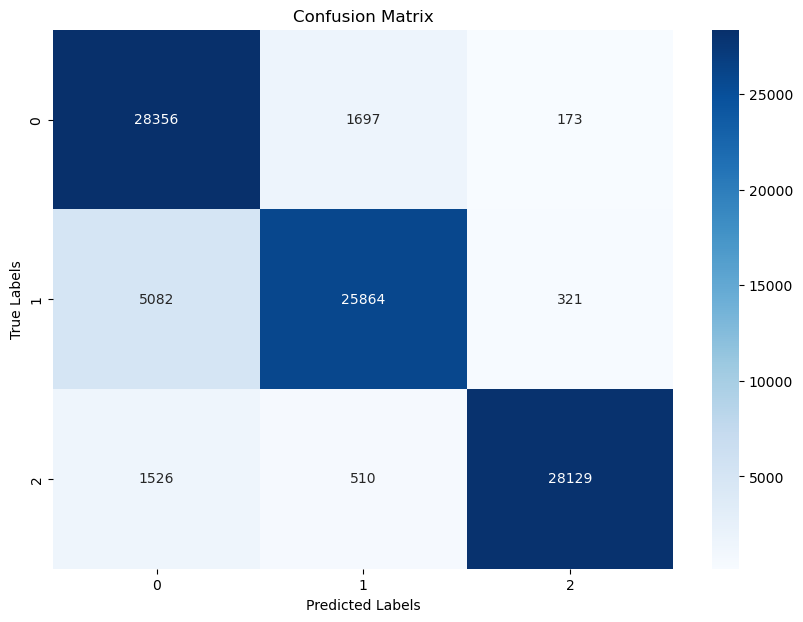

In [33]:
_, test_accuracy_cnn,f1_score_cnn = make_inference(cnn_model, test_loader, "mps",loss_fn)

In [34]:
test_accuracy,f1_score

(89.84376704706627, 0.899201033442191)

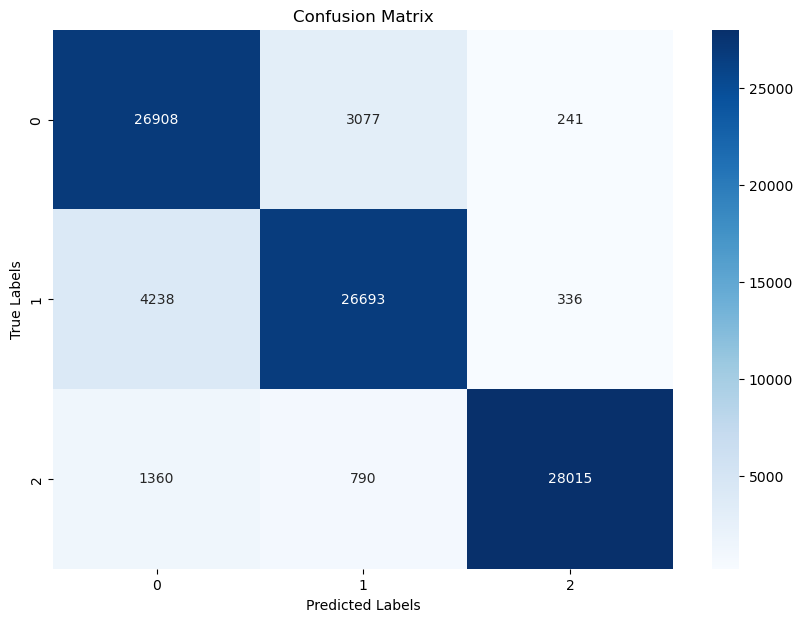

In [38]:
_, test_accuracy,f1_score = make_inference(lstm_model, test_loader, "mps",loss_fn)